# Module for Study the Data

## Importing Libraries

In [1]:
# Python Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.set_option('display.max_columns', 30)

# Suppress warnings to clean output
import warnings
warnings.filterwarnings("ignore")

## Load the Dataset

In [3]:
df = pd.read_csv('../Double_data/AUG_clear.csv', sep=',')
df.head()

,Number,Color,Hour,Minute,Day,Month,Year,Red bet,White bet,Black bet,Balance,Wallet,Red_per_hour,Black_per_hour,White_per_hour
0,5,1,0,0,1,1,2023,442.12,2330.36,234.00,2122.24,0.00,0.000000,0.000000,0.0
1,6,1,0,0,1,1,2023,4863.86,2561.12,298.34,-2004.40,-2004.40,1.000000,0.000000,0.0
2,6,1,0,1,1,1,2023,217.76,1533.86,316.59,1632.69,-371.71,1.000000,0.000000,0.0
3,11,2,0,1,1,1,2023,966.92,1846.41,321.74,2491.59,2119.88,0.666667,0.333333,0.0
4,9,2,0,2,1,1,2023,163.91,2546.52,1005.35,1705.08,3824.96,0.500000,0.500000,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89049 entries, 0 to 89048
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Number          89049 non-null  int64  
 1   Color           89049 non-null  int64  
 2   Hour            89049 non-null  int64  
 3   Minute          89049 non-null  int64  
 4   Day             89049 non-null  int64  
 5   Month           89049 non-null  int64  
 6   Year            89049 non-null  int64  
 7   Red bet         89049 non-null  float64
 8   White bet       89049 non-null  float64
 9   Black bet       89049 non-null  float64
 10  Balance         89049 non-null  float64
 11  Wallet          89049 non-null  float64
 12  Red_per_hour    89049 non-null  float64
 13  Black_per_hour  89049 non-null  float64
 14  White_per_hour  89049 non-null  float64
dtypes: float64(8), int64(7)
memory usage: 10.2 MB


## Local Functions

In [4]:
def frequency(color_name) -> list:
    """
        (function)
        color_name = string
        This function count how many times the selected color appeared in a selected period.
    """

    # True/False array for the selected color
    where_color_appeared = df['Color'] == color_name

    # How many times that color appeared (reset every hour)
    color_per_hour = where_color_appeared.cumsum()-where_color_appeared.cumsum().where(reset_time).ffill().fillna(0).astype(int)
    
    # How many colors (total) apperead (reset every hour)
    total_colors_array = pd.Series([True for x in range(df.shape[0])])
    total_colors_array = total_colors_array.cumsum()-total_colors_array.cumsum().where(reset_time).ffill().fillna(0).astype(int)
    total_colors_array = np.where(total_colors_array == 0, total_colors_array + 1, total_colors_array) # Adjust for 0 values = +1 -> Error: Can not divide by 0

    return color_per_hour / total_colors_array

## Feature creation

This first part is a study to research if the results are completely random or if they are predictable.

In [5]:
# Creation of a new feature:
# How many Black/Red/White colors appears whitin a day (in percentage)
reset_time = np.where((df['Hour'] == 0) & (df['Minute'] == 0) & (df['Minute'].shift(1).fillna(0) != 0), True, False)
colors = ['White', 'Red', 'Black']

for color in df.Color.unique():
    df[f'{colors[color]}_per_day'] = 0
    df[f'{colors[color]}_per_day'] = frequency(color)

# Creation of a new feature:
# How many times the Blaze won/lose consecutively
balance = pd.Series(np.where(df['Balance'] >= 0, True, False))
change1 = np.where(balance != True, True, False)
change2 = np.where(balance != False, True, False)

df['Positive'] = balance.cumsum()-balance.cumsum().where(change1).ffill().fillna(False).astype(int)
df['Negative'] = balance.eq(False).cumsum()-balance.eq(False).cumsum().where(change2).ffill().fillna(False).astype(int)

# Análise dos Dados

How the Blaze's Wallet behaves throughout the day

In [6]:
def plot_balance_graph(ammount:list, step:int):
    sns.set_style('darkgrid')
    plt.figure(figsize=(20, 12))
    ax = plt.subplot(len(ammount) - 1, 1, 1)

    for n in range(len(ammount) - 1):
        plt.subplot(3, 1, n + 1)
        plt.plot(df.index[ammount[n]:ammount[n+1]:step], df['Wallet'][ammount[n]:ammount[n+1]:step], label='Blaze\'s Wallet Ammount')

        days = df.Day[ammount[n]:ammount[n+1]:step]

        for key, day in enumerate(days):
            if day != days.values[key-1]:
                plt.scatter(days.index[key], df['Wallet'][days.index[key]], color='red', s=50, label='Day change' if key == 0 else None)

        plt.ticklabel_format(useOffset=False, style='Plain')

        current_values = plt.gca().get_yticks()
        plt.gca().set_yticklabels(['{:,.0f}'.format(x).replace(',', '.') for x in current_values])

        current_values = plt.gca().get_xticks()

        plt.gca().set_xticklabels([df['Day'].values[int(x)] for x in current_values if x >= 0])
        plt.legend()
        plt.xlabel('Days')
        plt.ylabel('Ammount (R$ - BRL)')
    plt.show()

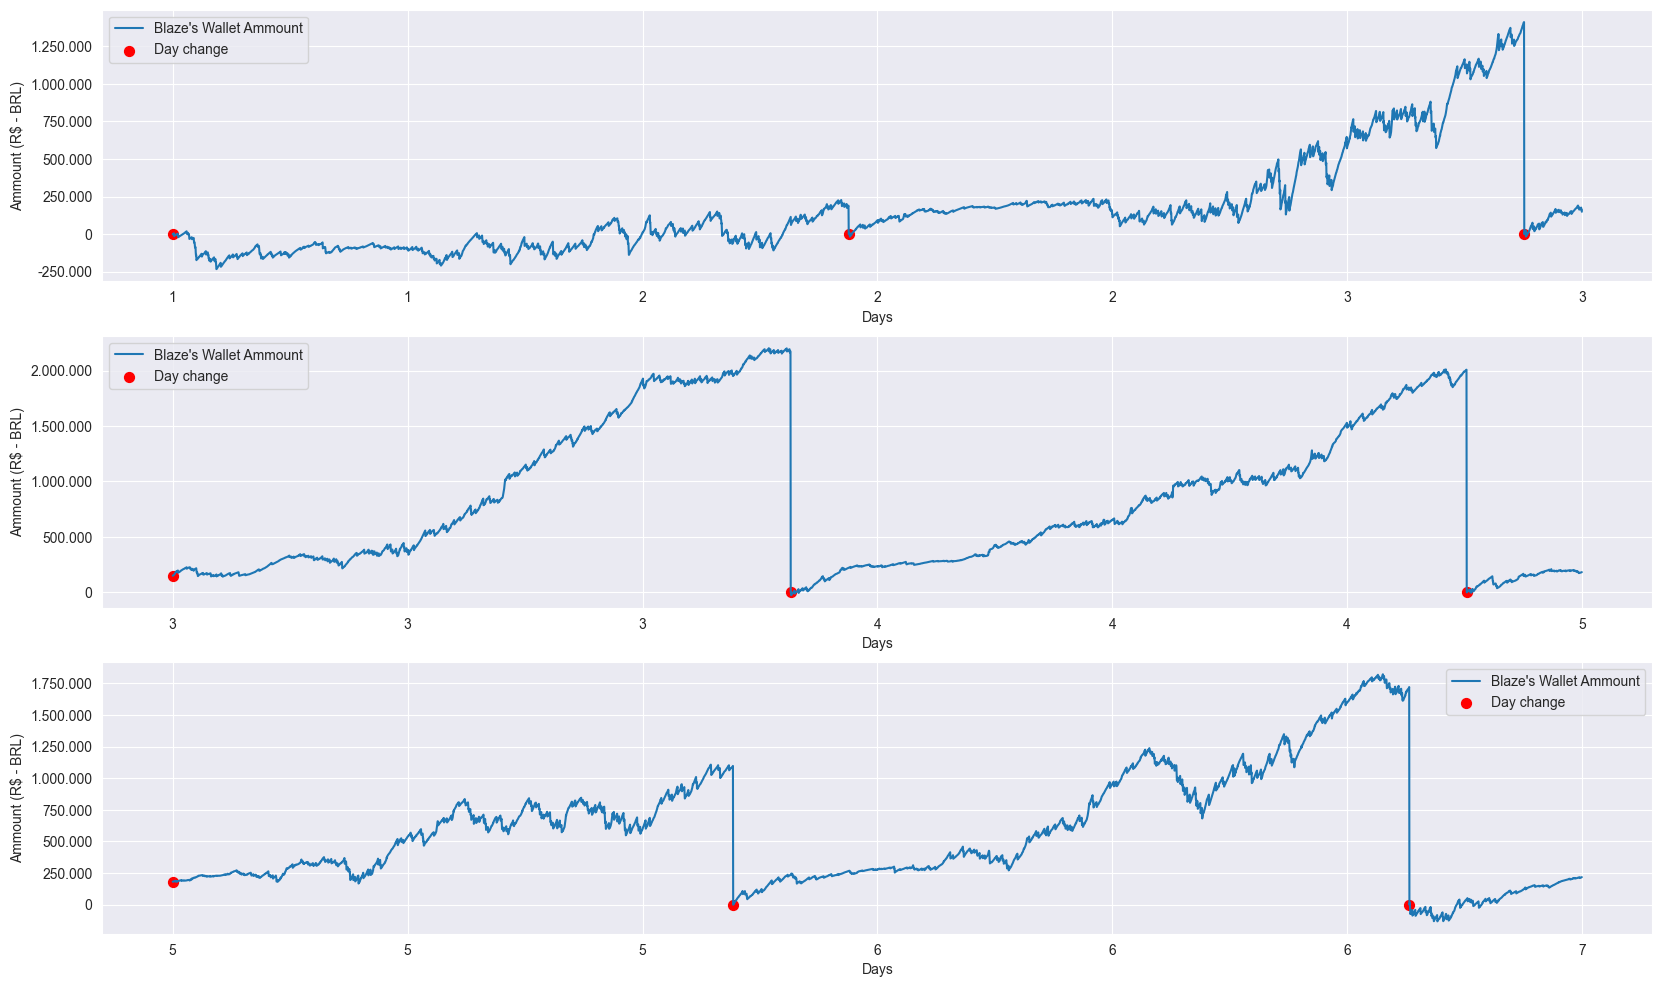

In [7]:
# Can the behave be determined after the day change?

plot_balance_graph(ammount=[0, 6_000, 12_000, 18_000], step=1)

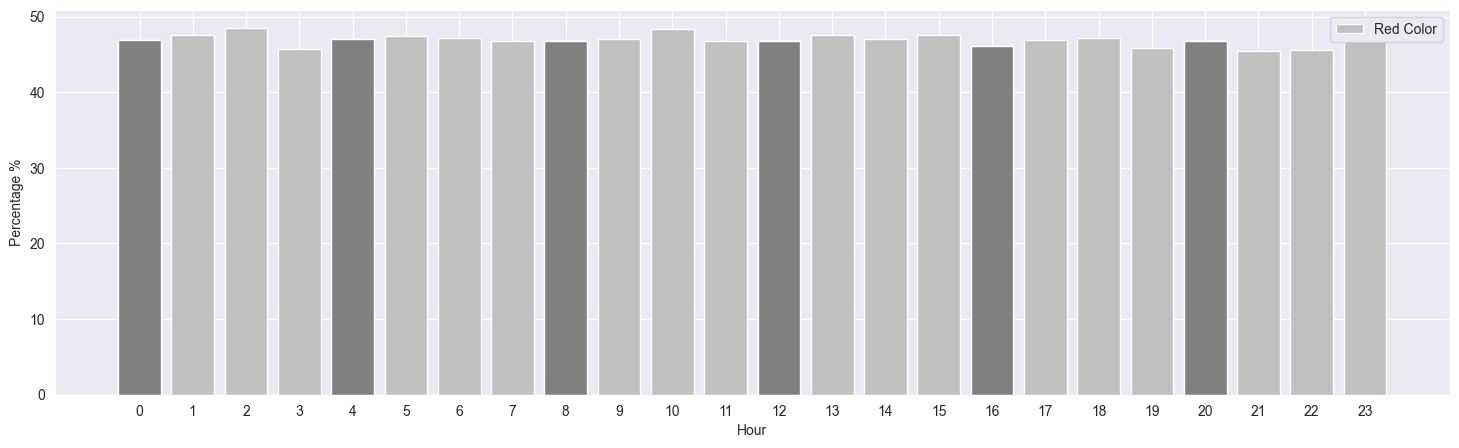

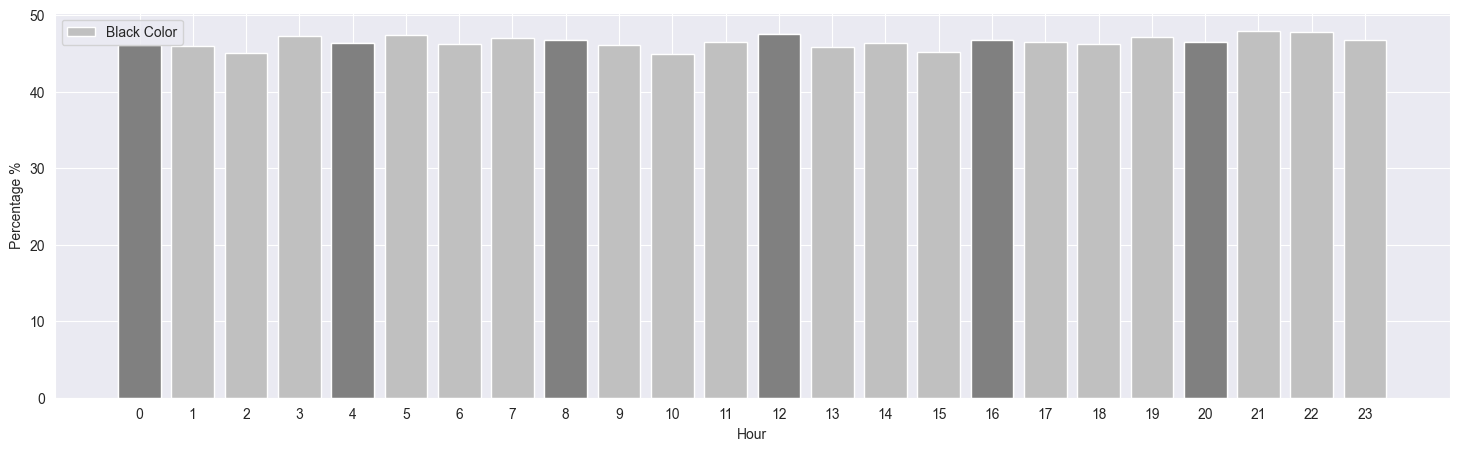

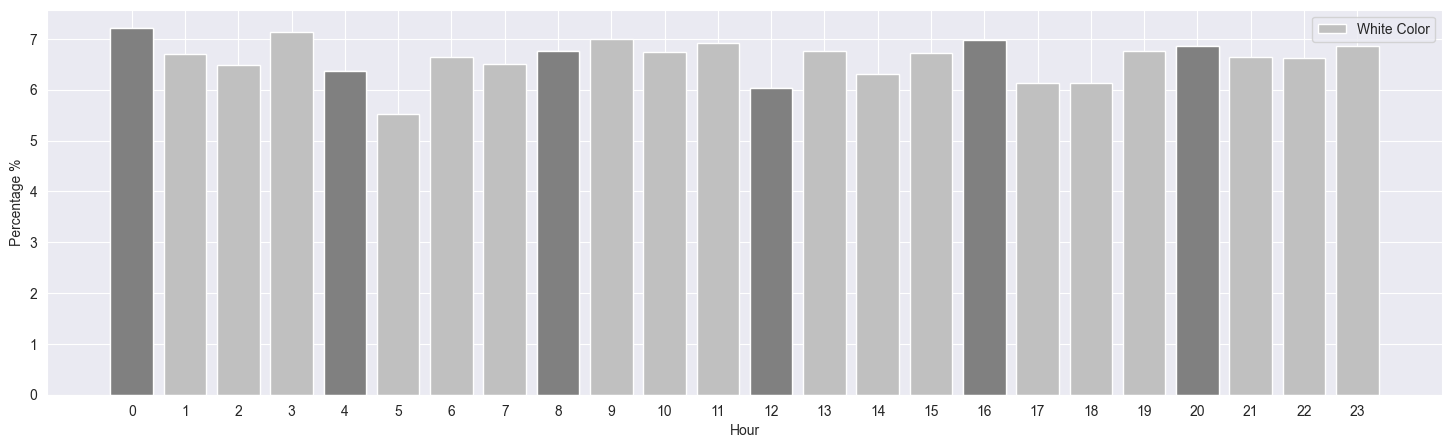

In [8]:
colors = ['White', 'Red', 'Black']

for c in df.Color.unique():
    plt.figure(figsize=(18, 5))

    time = 'Hour' # 'Minute

    color_ = ((df.loc[df.Color == c][time].value_counts()) / df.groupby('Hour')[time].value_counts().values * 100).sort_index()
    plt.bar(color_.index, color_.values, color='silver', label=f'{colors[c]} Color')

    for n in color_.index[::4]:
        plt.bar(color_.index[n], color_.values[n], color='gray')

    plt.ylabel('Percentage %')
    plt.xlabel(f'{time}')
    plt.legend()
    plt.xticks(df[time].unique())
    plt.show()

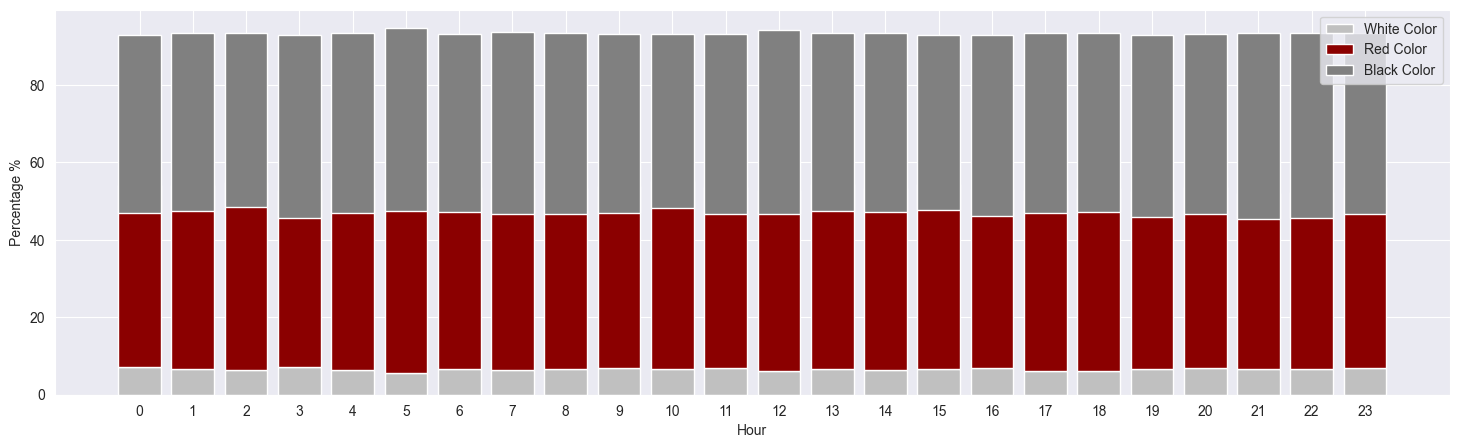

In [9]:
colors = ['White', 'Red', 'Black']

plt.figure(figsize=(18, 5))

time = 'Hour' # 'Minute

color0 = ((df.loc[df.Color == 0][time].value_counts()) / df.groupby('Hour')[time].value_counts().values * 100).sort_index()
plt.bar(color0.index, color0.values, color='silver', label=f'{colors[0]} Color')

color1 = ((df.loc[df.Color == 1][time].value_counts()) / df.groupby('Hour')[time].value_counts().values * 100).sort_index()
plt.bar(color1.index, color1.values, color='darkred', label=f'{colors[1]} Color', bottom=color0.values)

color2 = ((df.loc[df.Color == 2][time].value_counts()) / df.groupby('Hour')[time].value_counts().values * 100).sort_index()
plt.bar(color2.index, color2.values, color='gray', label=f'{colors[2]} Color', bottom=color1.values)

plt.ylabel('Percentage %')
plt.xlabel(f'{time}')
plt.legend()
plt.xticks([n for n in range(0, df[time].unique()[-1] + 1)])
plt.show()

## How many times did players beat the house?

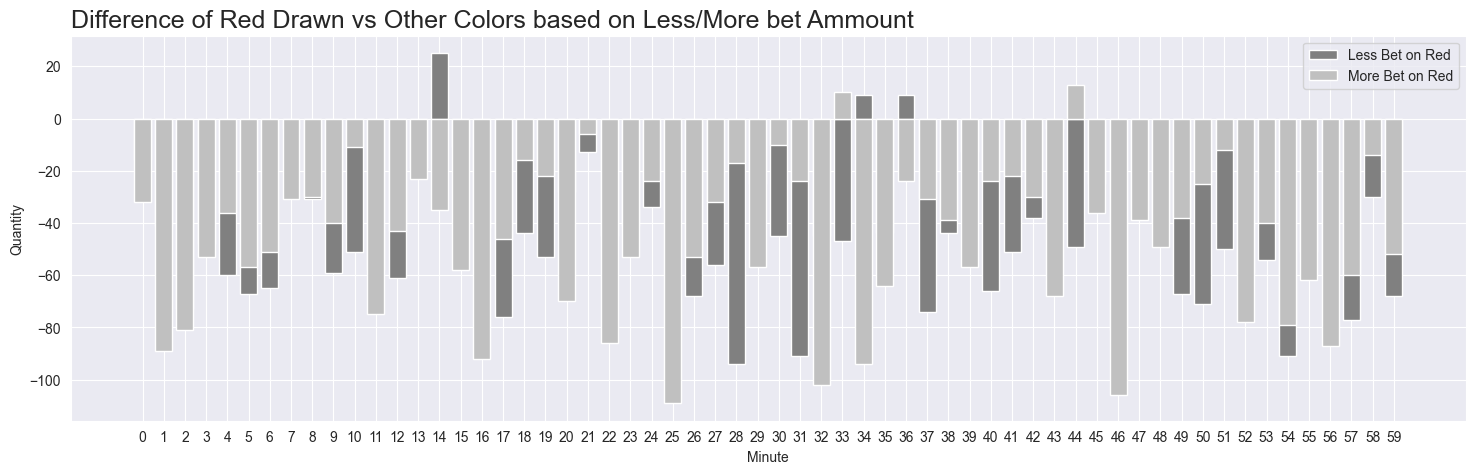

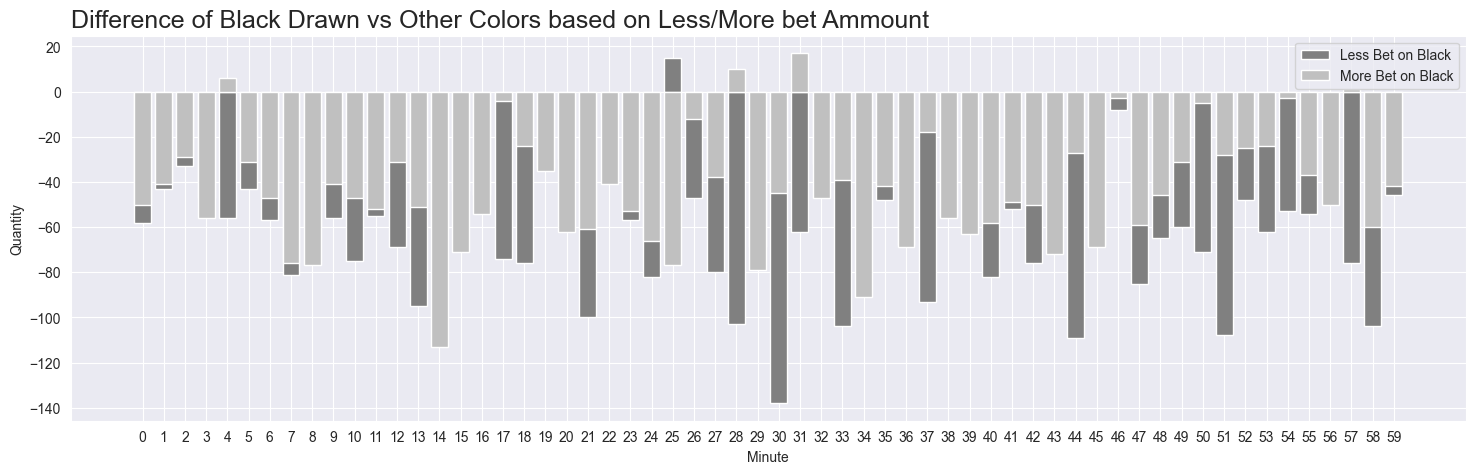

In [10]:
for c in [1, 2]:
    plt.figure(figsize=(18, 5))

    time = 'Minute'

    # The other color has more money than the chosen one
    color_ = (df.loc[(df.Color == c) & (df[f'{colors[::-1][c-1]} bet'] > df[f'{colors[c]} bet'])][time].value_counts()).sort_index()
    color_not = (df.loc[(df.Color != c) & (df[f'{colors[::-1][c-1]} bet'] > df[f'{colors[c]} bet'])][time].value_counts()).sort_index()
    color_1 = color_ - color_not #color_ / (color_ + color_not) * 100
    plt.bar(color_.index, color_1.values, color='gray', label=f'Less Bet on {colors[c]}')

    # The color chosen has more money than the other
    color_ = (df.loc[(df.Color == c) & (df[f'{colors[::-1][c-1]} bet'] < df[f'{colors[c]} bet'])][time].value_counts()).sort_index()
    color_not = (df.loc[(df.Color != c) & (df[f'{colors[::-1][c-1]} bet'] < df[f'{colors[c]} bet'])][time].value_counts()).sort_index()
    color_2 = color_ - color_not #color_ / (color_ + color_not) * 100
    plt.bar(color_.index, color_2.values, color='silver', label=f'More Bet on {colors[c]}')

    plt.title(f'Difference of {colors[c]} Drawn vs Other Colors based on Less/More bet Ammount', fontsize=18, loc='left')
    plt.ylabel('Quantity')
    plt.xlabel(f'{time}')
    plt.legend(loc='upper right')
    plt.xticks([n for n in range(0, 60)])
    plt.show()

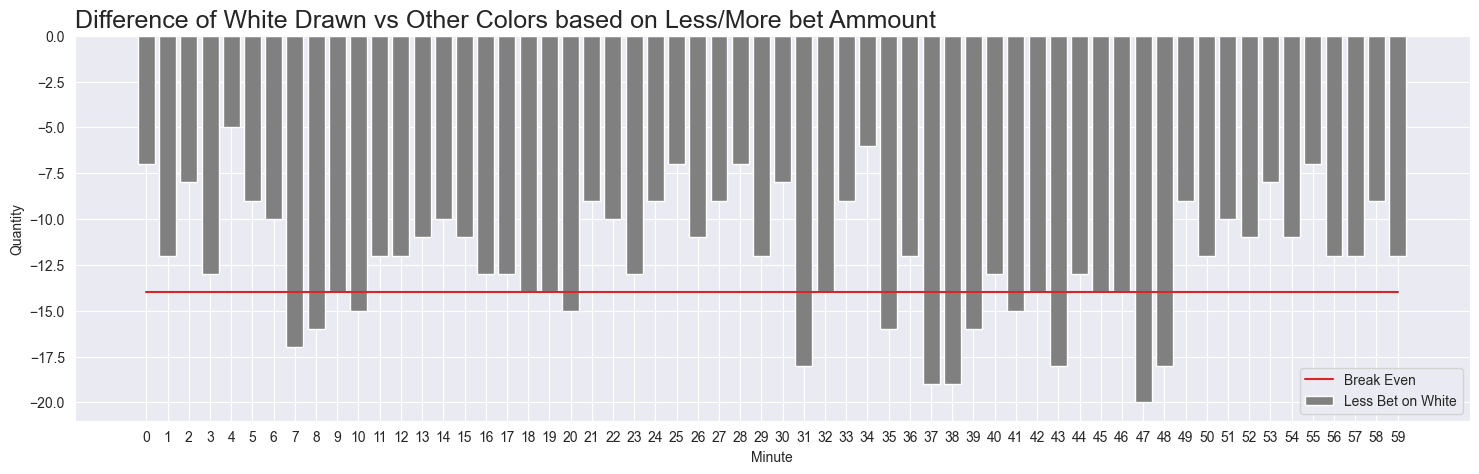

In [11]:
# Same graph for White Bet - the difference is that the White Bet must be bigger or lower than Red + Black bets

plt.figure(figsize=(18, 5))

time = 'Minute'

color_ = pd.DataFrame(df.loc[(df.Color == 0) & (df['White bet'] < df[f'Black bet']) & (df['White bet'] < df[f'Red bet'])][time].value_counts()).sort_index()
color_not = pd.DataFrame(df.loc[(df.Color != 0) & (df['White bet'] < df[f'Black bet']) & (df['White bet'] < df[f'Red bet'])][time].value_counts()).sort_index()
color_1 = pd.merge(color_not, color_, how='outer', left_index=True, right_index=True, suffixes = ('_left', '_right')).fillna(0)
color_1 = color_1['Minute_right'] - color_1['Minute_left']
plt.bar(color_1.index, color_1.values, color='gray', label=f'Less Bet on {colors[0]}')

plt.plot([x for x in range(60)], [-14 for x in range(60)], color='tab:red', label='Break Even')

plt.title('Difference of White Drawn vs Other Colors based on Less/More bet Ammount', fontsize=18, loc='left')
plt.ylabel('Quantity')
plt.xlabel(f'{time}')
plt.legend(loc='lower right')
plt.xticks([n for n in range(0, 60)])
plt.show()

These graphs shows that there is no correlation between players bet and the Blaze's Color.

## How many times white appeared close to another white?

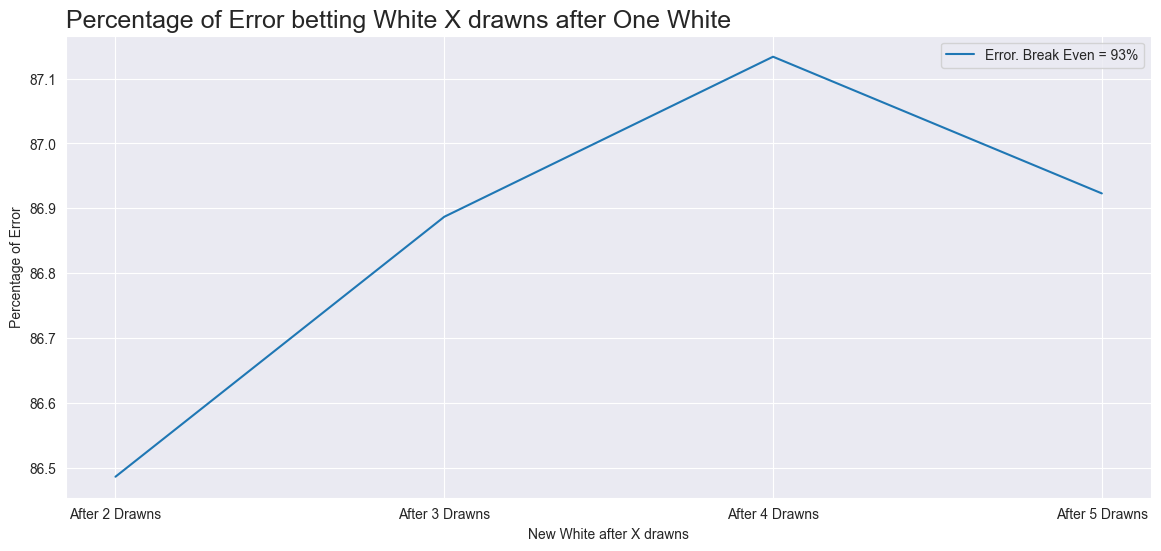

In [12]:
for n in range(2, 6):
    df[f'White_close{n}'] = np.where((df['Color'].shift(1).rolling(n).min() == 0), True, False)
    # df['White_close'] = df['White_close'].shift(1).fillna(False)

sns.set_style('darkgrid')
true_values = df.loc[
    (df['Color'] == 0) & ((df['White_close2'] == True) | (df['White_close3'] == True) | (df['White_close4'] == True) | (df['White_close5'] == True))
][['White_close2', 'White_close3', 'White_close4', 'White_close5']].sum().values
false_values = df.loc[
    (df['Color'] != 0) & ((df['White_close2'] == True) | (df['White_close3'] == True) | (df['White_close4'] == True) | (df['White_close5'] == True))
][['White_close2', 'White_close3', 'White_close4', 'White_close5']].sum().values

profit = (false_values - true_values) / (true_values + false_values) * 100

plt.figure(figsize=(14, 6))
plt.plot(profit, label='Error. Break Even = 93%')
plt.gca().set_xticks([x for x in range(4)])
plt.gca().set_xticklabels(['After 2 Drawns', 'After 3 Drawns', 'After 4 Drawns', 'After 5 Drawns'])

plt.title('Percentage of Error betting White X drawns after One White', loc='left', fontsize=18)
plt.xlabel('New White after X drawns')
plt.ylabel('Percentage of Error')
plt.legend()
plt.show()

## How many of each color were drawn in each hour?

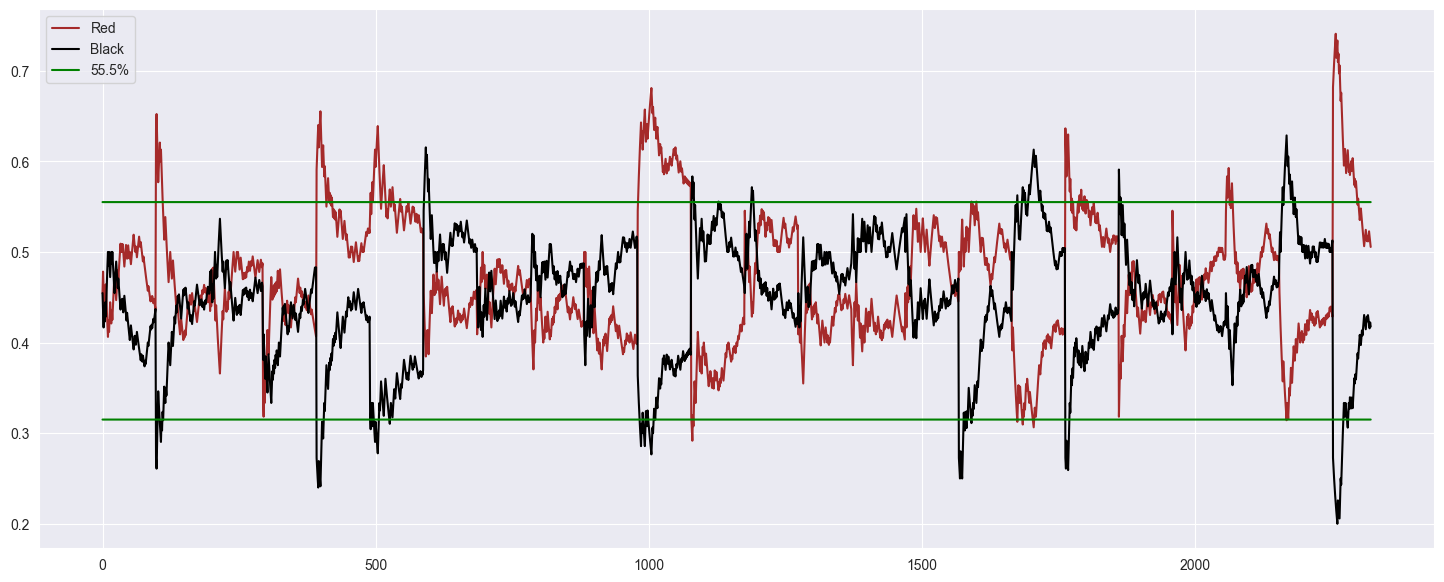

In [13]:
sns.set_style('darkgrid')

plt.figure(figsize=(18, 7))
df_plot = df.loc[(df.index > 0)&(df.index < 2850)&(df.Minute > 10)]#&(df.Red_per_day > 0.4)&(df.Black_per_day > 0.4)]

plt.plot([n for n in range(df_plot.shape[0])],
          df_plot['Red_per_hour'], color='brown', label='Red')

plt.plot([n for n in range(df_plot.shape[0])],
          df_plot['Black_per_hour'], color='Black', label='Black')

plt.plot([n for n in range(df_plot.shape[0])], 
         [0.555 for n in range(df_plot.shape[0])], color='green', label='55.5%')

plt.plot([n for n in range(df_plot.shape[0])], 
         [0.315 for n in range(df_plot.shape[0])], color='green')

plt.legend()
plt.show()

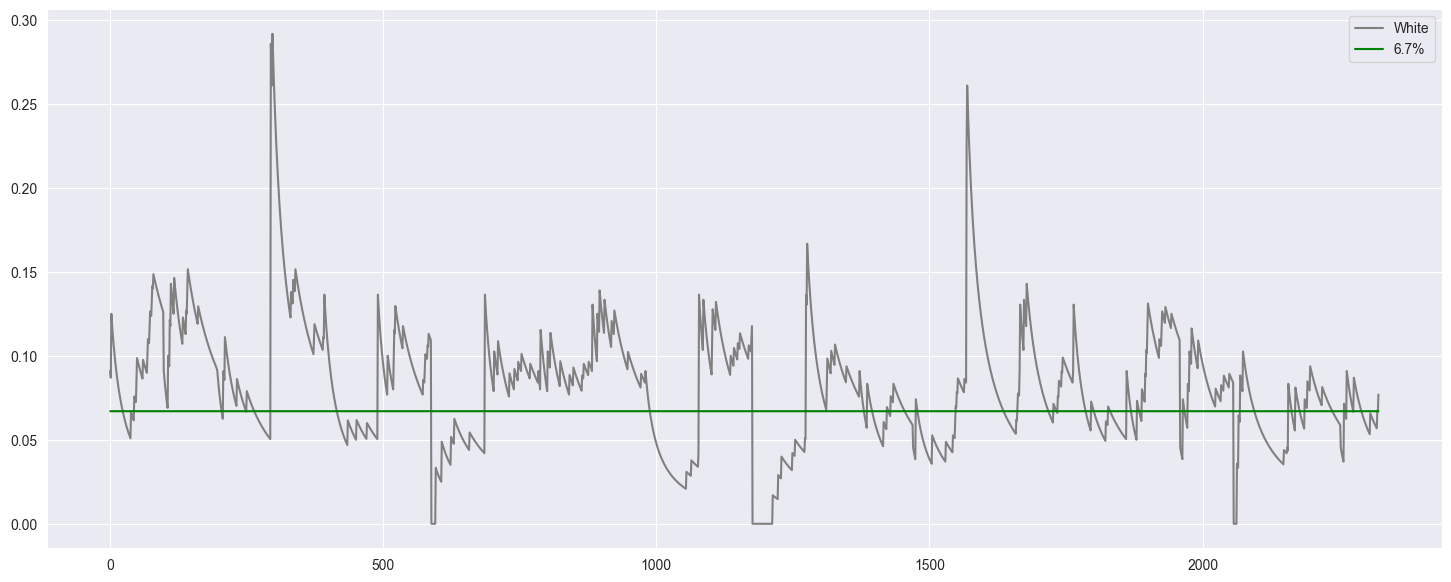

In [14]:
# Same graph, but just for White Bet

sns.set_style('darkgrid')

plt.figure(figsize=(18, 7))
df_plot = df.loc[(df.index > 0)&(df.index < 2850)&(df.Minute > 10)]

plt.plot([n for n in range(df_plot.shape[0])],
          df_plot['White_per_hour'], color='gray', label='White')

plt.plot([n for n in range(df_plot.shape[0])], 
         [0.067 for n in range(df_plot.shape[0])], color='green', label='6.7%')

plt.legend()
plt.show()

## Create dispersion and color graphs

How much data < or > some % per hour

After creating all these features, now it's time to check the correlation matrix and see which columns to keep and which to drop.

In [15]:
# Correlation matrix
# Month and Year don't change = drop
# Some features are just known after the color drawn (such as {Color}_per_hour), so it's necessary to shift by 1 these features
correlation_df = pd.concat(
    [df[['Number', 'Color', 'Hour', 'Minute', 'Day', 'Month', 'Year', 'Red bet', 'White bet', 'Black bet', 'White_close2', 'White_close3', 'White_close4', 'White_close5']],
     df[['Balance', 'Wallet', 'Black_per_hour', 'Red_per_hour', 'White_per_hour', 'Black_per_day', 'Red_per_day', 'White_per_day', 'Positive', 'Negative']].shift(1)],
    axis=1
).dropna()

correlation_df.drop(['Month', 'Year'], axis=1).corr().style.background_gradient(cmap='RdBu', vmin=-1, vmax=1).set_sticky(axis='index')

,Number,Color,Hour,Minute,Day,Red bet,White bet,Black bet,White_close2,White_close3,White_close4,White_close5,Balance,Wallet,Black_per_hour,Red_per_hour,White_per_hour,Black_per_day,Red_per_day,White_per_day,Positive,Negative
Number,1.000000,0.883533,0.004050,0.000702,0.000765,0.002390,0.000235,-0.002907,0.001017,0.001029,0.002937,0.000731,0.001593,0.008964,0.001524,-0.001356,0.001130,-0.001757,0.000348,0.000843,-0.003301,0.017155
Color,0.883533,1.000000,0.005147,-0.000461,-0.000215,-0.001138,-0.000915,-0.005369,0.000006,-0.001076,0.002469,0.000259,0.003768,0.011856,-0.000071,-0.000108,0.001537,-0.004153,0.002416,0.000424,-0.005553,0.019826
Hour,0.004050,0.005147,1.000000,-0.000191,-0.000291,0.263109,0.257236,0.304114,0.000454,0.001753,0.001717,0.001382,0.003232,0.553027,0.033272,-0.024393,-0.019146,0.068060,-0.008802,-0.079077,0.000188,-0.009791
Minute,0.000702,-0.000461,-0.000191,1.000000,0.000210,-0.006012,0.000081,-0.004423,0.004902,0.007384,0.008551,0.009319,-0.000882,0.021399,0.052853,0.062090,0.021498,0.004902,0.014940,-0.001426,0.000812,0.002318
Day,0.000765,-0.000215,-0.000291,0.000210,1.000000,-0.039998,0.090381,-0.063997,0.001249,0.002099,0.002527,0.003148,-0.001173,0.054435,0.020281,-0.004794,-0.034317,0.087867,-0.068428,-0.029705,0.077098,-0.030783
Red bet,0.002390,-0.001138,0.263109,-0.006012,-0.039998,1.000000,0.244230,0.079722,-0.009299,-0.016203,-0.010272,-0.002657,0.013036,0.097505,0.079658,-0.097875,0.040752,0.047277,-0.055637,0.016923,-0.013508,0.017097
White bet,0.000235,-0.000915,0.257236,0.000081,0.090381,0.244230,1.000000,0.280895,-0.018078,-0.006831,-0.019036,-0.025382,0.047554,-0.030864,0.014161,-0.045807,0.060895,0.156776,-0.217327,0.151345,0.131675,-0.044950
Black bet,-0.002907,-0.005369,0.304114,-0.004423,-0.063997,0.079722,0.280895,1.000000,-0.007747,-0.023524,-0.015763,-0.009757,0.004174,0.119821,-0.113786,0.095384,0.048143,0.008997,-0.014147,0.010163,-0.007314,0.020550
White_close2,0.001017,0.000006,0.000454,0.004902,0.001249,-0.009299,-0.018078,-0.007747,1.000000,0.802749,0.682648,0.599041,-0.495156,-0.035229,-0.057949,-0.059911,0.265502,-0.006822,-0.024437,0.074851,-0.297507,0.501643
White_close3,0.001029,-0.001076,0.001753,0.007384,0.002099,-0.016203,-0.006831,-0.023524,0.802749,1.000000,0.850387,0.746237,-0.399313,-0.041782,-0.066496,-0.066347,0.298971,-0.007454,-0.027694,0.085979,-0.349050,0.395321


# Machine Learning Algorithm

It will use two similar Datasets and 4 different algorithms and try to predict the 'Number' and the 'Color'.

The first dataset will use only the information that can be obtained 1 second before the drawn and will be named as 'snapshot_df'.

The second dataset will contain all the information about the day and hour (shifted by 1) and as known as 'correlation_df'.

In [16]:
snapshot_df = df[['Number', 'Color', 'Hour', 'Minute', 'Day', 'Red bet', 'White bet', 'Black bet', 'White_close2', 'White_close3', 'White_close4', 'White_close5']]

snapshot_df['Color'] = snapshot_df['Color'].map({0:1, 1:0, 2:0}) # White = 1; Black + Red = 0
snapshot_df.Color.value_counts() / snapshot_df.shape[0] * 100

0    93.383418
1     6.616582
Name: Color, dtype: float64

## Baseline
The Baseline for White is 6.616% (the color that could be more profitable)

Import common modules to all algoirhtms

In [17]:
from sklearn.model_selection import cross_validate, StratifiedKFold, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint

Selecting 2 Machine Learning Algorithms

In [39]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

SKLearn CPU Accelerator

In [19]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [20]:
# Selecting the seed for future reproduction
SEED = 301
np.random.seed(SEED)

# Manipulating the first dataset
y1 = snapshot_df['Number'] # Regressor
y2 = snapshot_df['Color']  # Classifier

x = snapshot_df[['Hour', 'Minute', 'Day', 'Red bet', 'White bet', 'Black bet', 'White_close2', 'White_close3', 'White_close4', 'White_close5']]

# Scaling the data
scaler = StandardScaler()
x = scaler.fit_transform(x)

# Setting the parameters to search
params = {
    'n_estimators':randint(100, 1000),
    'max_depth':randint(4, 32),
    'min_samples_split':randint(32, 128),
    'min_samples_leaf':randint(32, 128),
    'criterion':['gini', 'entropy'],
    'bootstrap':[True, False],
    'class_weight':['balanced']
}

# Place it all together
search1 = RandomizedSearchCV(
    RandomForestClassifier(),
    param_distributions=params,
    cv=StratifiedKFold(n_splits=2, shuffle=True),
    scoring='recall',
    n_iter=5,
    n_jobs=-1
)

search1.fit(x, y2)
results = pd.DataFrame(search1.cv_results_)
print(search1.best_score_)
print(search1.best_estimator_)
results.head()

0.31466395112016293
RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=11,
                       min_samples_leaf=100, min_samples_split=50,
                       n_estimators=335)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_class_weight,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,67.103274,0.289488,2.270989,0.039525,False,balanced,gini,11,100,50,335,"{'bootstrap': False, 'class_weight': 'balanced...",0.291242,0.338086,0.314664,0.023422,1
1,191.406942,3.121325,4.738627,0.299786,False,balanced,entropy,19,66,108,576,"{'bootstrap': False, 'class_weight': 'balanced...",0.202648,0.198235,0.200441,0.002206,2
2,83.007192,0.313893,4.430284,0.038327,True,balanced,gini,12,102,46,642,"{'bootstrap': True, 'class_weight': 'balanced'...",0.166327,0.183639,0.174983,0.008656,3
3,108.872428,0.407484,4.558457,0.042678,True,balanced,entropy,20,84,99,552,"{'bootstrap': True, 'class_weight': 'balanced'...",0.099117,0.123218,0.111168,0.012050,4
4,87.788219,0.960973,4.669757,0.031963,True,balanced,gini,27,57,73,524,"{'bootstrap': True, 'class_weight': 'balanced'...",0.057366,0.076714,0.067040,0.009674,5


In [40]:
# Setting the parameters to search
params = {
    'booster':['gbtree', 'gblinear', 'dart'],
    'eta':[x / 100 for x in range(1, 21)],
    'learning_rate':[0.1],
    'n_estimators':[1000],
    'max_depth':[1, 2, 4, 16, 32, 64, 128, 256, 512],
    'min_child_weight':[1, 2, 4, 16, 32, 64, 128, 256, 512],
    'gamma':[0.1, 0.2, 0.4, 0.16, 0.32, 0.64, 0.128, 0.256, 0.512],
    'subsample':[0.1, 0.2, 0.4, 0.8, 1],
    'colsample_bytree':[0.1, 0.2, 0.4, 0.8, 1],
    'objective':['binary:logistic', 'binary:logitraw'],
    'tree_method':['gpu_hist']
}

# Place it all together
search2 = RandomizedSearchCV(
    XGBClassifier(),
    param_distributions=params,
    cv=StratifiedKFold(n_splits=2, shuffle=True),
    n_iter=5,
    verbose=2
)

search2.fit(x, y2)
results2 = pd.DataFrame(search2.cv_results_)
print(search2.best_score_, search2.best_estimator_)
results.head()

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END booster=dart, colsample_bytree=0.1, eta=0.14, gamma=0.1, learning_rate=0.1, max_depth=32, min_child_weight=512, n_estimators=1000, objective=binary:logitraw, subsample=0.2, tree_method=gpu_hist; total time= 6.5min
[CV] END booster=dart, colsample_bytree=0.1, eta=0.14, gamma=0.1, learning_rate=0.1, max_depth=32, min_child_weight=512, n_estimators=1000, objective=binary:logitraw, subsample=0.2, tree_method=gpu_hist; total time= 6.9min
[CV] END booster=dart, colsample_bytree=0.1, eta=0.09, gamma=0.2, learning_rate=0.1, max_depth=64, min_child_weight=128, n_estimators=1000, objective=binary:logitraw, subsample=0.2, tree_method=gpu_hist; total time= 7.0min
[CV] END booster=dart, colsample_bytree=0.1, eta=0.09, gamma=0.2, learning_rate=0.1, max_depth=64, min_child_weight=128, n_estimators=1000, objective=binary:logitraw, subsample=0.2, tree_method=gpu_hist; total time= 6.9min
[CV] END booster=gbtree, colsample_bytree=0.1, e

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,11.394309,0.897098,0.156843,0.003517,True,23,100,86,25,"{'bootstrap': True, 'max_depth': 23, 'min_samp...",-18.815976,-18.745818,-18.780897,0.035079,3
1,33.004817,8.223110,0.347157,0.049167,False,31,32,109,43,"{'bootstrap': False, 'max_depth': 31, 'min_sam...",-20.272423,-19.873358,-20.072891,0.199533,5
2,18.895611,0.756229,0.227099,0.001388,True,14,52,80,44,"{'bootstrap': True, 'max_depth': 14, 'min_samp...",-18.795034,-18.699341,-18.747188,0.047846,2
3,1.268224,0.005250,0.013782,0.001258,False,4,87,117,7,"{'bootstrap': False, 'max_depth': 4, 'min_samp...",-18.762860,-18.695697,-18.729278,0.033581,1
4,42.108973,3.369024,0.390728,0.046097,False,12,58,65,95,"{'bootstrap': False, 'max_depth': 12, 'min_sam...",-19.273569,-18.785693,-19.029631,0.243938,4


## Validating the model

In [4]:
df_test = pd.read_csv('../Double_data/OUT_test.csv')

df_test['Color'] = df_test['Color'].map({'White':0, 'Red':1, 'Black':2})

for n in range(2, 6):
    df_test[f'White_close{n}'] = np.where((df_test['Color'].shift(1).rolling(n).min() == 0), True, False)

df_test['Color'] = df_test['Color'].map({0:1, 1:0, 2:0})

df_test.head()

,Number,Color,Hour,Minute,Day,Red bet,White bet,Black bet,White_close2,White_close3,White_close4,White_close5
0,1,0,0,0,1,0.000000,0.00,0.00,False,False,False,False
1,12,0,0,0,1,0.000000,0.00,0.00,False,False,False,False
2,11,0,0,1,1,0.000000,0.00,0.00,False,False,False,False
3,10,0,0,1,1,0.000000,0.00,0.00,False,False,False,False
4,6,0,0,2,1,39491.566667,22803.09,2745.17,False,False,False,False


In [48]:
def show_accuracy(model:object, key:int) -> None:
    best_model = model.best_estimator_

    x_test = df_test[['Hour', 'Minute', 'Day', 'Red bet', 'White bet', 'Black bet', 'White_close2', 'White_close3', 'White_close4', 'White_close5']]
    x_test = scaler.transform(x_test)

    predict = best_model.predict(x_test)

    df_test['Predict'] = predict

    feature = 'Number' if key >= 2 else 'Color'

    right_values = df_test.loc[df_test['Predict'] == df_test[feature]]['Predict'].value_counts()
    wrong_values = df_test.loc[df_test['Predict'] != df_test[feature]]['Predict'].value_counts()

    accuracy = right_values / (right_values + wrong_values) * 100
    print(model.best_estimator_)
    print(accuracy)

In [49]:
search_list = [search1, search2]

for key, search in enumerate(search_list):
    show_accuracy(search, key)

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=11,
                       min_samples_leaf=100, min_samples_split=50,
                       n_estimators=335)
0    93.230506
1     6.518039
Name: Predict, dtype: float64
XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.1, early_stopping_rounds=None,
              enable_categorical=False, eta=0.14, eval_metric=None,
              feature_types=None, gamma=0.1, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=32,
              max_leaves=None, min_child_weight=512, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, objective='binary:logitraw', ...)


## Saving the models

In [56]:
import pickle as cPickle

for key, search in enumerate(search_list):
    cPickle.dump(search.best_estimator_, open(f'search{key + 1}.pkl', 'wb'))

# Automated Test (Old Version)

In [ ]:
import datetime
from clean_database import clean_data_today, update_today
clean_data_today()

In [ ]:
def hora(data):
    return int(data[-5:-3])

def minuto(data):
    return int(data[-2:])

color = ['White', 'Black', 'Red']

In [ ]:
now = datetime.datetime.now()

df_dia = pd.read_csv(r'\blaze_algorithm\JS\today-CLEAN.csv')
df_dia.drop('Unnamed: 0', axis=1, inplace=True)

df_atual = pd.read_csv(r'C:\Users\gdcam\OneDrive\Área de Trabalho\DS BLAZE\blaze_algorithm\JS\mamaco.csv')
df_atual['Hour'] = df_atual['Data'].apply(lambda row: hora(row))
df_atual['Minute'] = df_atual.Data.apply(lambda row: minuto(row))
df_atual.drop_duplicates(subset=['Número', 'Hour', 'Minute'], keep='last', inplace=True)
df_atual = df_atual.fillna(0)
df_atual = df_atual.loc[df_atual.Hour == now.hour]
tamanho = df_atual.shape[0] - 1

with open(r'\blaze_algorithm\JS\snapshot.csv', "r") as f1:
    file = f1.readlines()[-1]

    try:
        black_bet = float(file[3:file.find(',')]) * 3
        int(black_bet)
        white_bet = float(file[file.find(',')+3:file.rfind(',')]) * 3
        red_bet = float(file[file.rfind(',')+3:]) * 3

    except:
        black_bet = 0
        white_bet = 0
        red_bet = 0 

black_per_hour = df_atual.loc[df_atual.Número > 7]['Número'].count() / tamanho
white_per_hour = df_atual.loc[df_atual.Número == 0]['Número'].count() / tamanho
red_per_hour = df_atual.loc[(df_atual.Número >= 1)&(df_atual.Número <= 7)]['Número'].count() / tamanho


num_previsto = model1.predict([[now.hour, now.minute, red_bet, white_bet, black_bet, df_dia.iloc[-1, 3], df_dia.iloc[-1, 2],
                               black_per_hour, red_per_hour, white_per_hour]])

cor = model2.predict([[num_previsto, now.hour, now.minute, red_bet, white_bet, black_bet, df_dia.iloc[-1, 3], df_dia.iloc[-1, 2],
                               black_per_hour, red_per_hour, white_per_hour]])

if num_previsto > 7 and int(cor) == 1:
    print(color[int(cor)])

elif num_previsto == 0 and int(cor) == 0:
    print(color[int(cor)])

elif num_previsto >= 1 and num_previsto <= 7 and int(cor) == 2:
    print(color[int(cor)])

else:
    print('Nada a se fazer')

df_atual = pd.read_csv(r'C:\Users\gdcam\OneDrive\Área de Trabalho\DS BLAZE\blaze_algorithm\JS\mamaco.csv')
df_atual['Hour'] = df_atual['Data'].apply(lambda row: hora(row))
df_atual['Minute'] = df_atual.Data.apply(lambda row: minuto(row))
df_atual.drop_duplicates(subset=['Número', 'Hour', 'Minute'], keep='last', inplace=True)

df_atual[['Red Bet']] = df_atual[['Red Bet']].replace(['[\$,]', '[R,]'], '', regex=True).astype(float)
df_atual[['Black Bet']] = df_atual[['Black Bet']].replace(['[\$,]', '[R,]'], '', regex=True).astype(float)
df_atual[['White Bet']] = df_atual[['White Bet']].replace(['[\$,]', '[R,]'], '', regex=True).astype(float)

df_atual['Balance'] = 0

df_atual.loc[(df_atual['Número'] >= 8), 'Balance'] = df_atual['Red Bet'] + df_atual['White Bet'] + df_atual['Black Bet'] - 2 * df_atual['Black Bet']
df_atual.loc[(df_atual['Número'] >= 1)&(df_atual['Número'] <= 7), 'Balance'] = df_atual['Black Bet'] + df_atual['White Bet'] + df_atual['Red Bet'] - 2 * df_atual['Red Bet']
df_atual.loc[(df_atual['Número'] == 0), 'Balance'] = df_atual['Red Bet'] + df_atual['White Bet'] + df_atual['Black Bet'] - 14 * df_atual['White Bet']

update_today(df_dia, df_atual)

Nada a se fazer
